# Physical Beamformer testing

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pyroomacoustics as pra
from pyroomacoustics.directivities import (
    DirectivityPattern,
    DirectionVector,
    CardioidFamily,
)
from scipy.io import wavfile
from scipy.signal import resample
from playsound import playsound
from os import listdir
from os.path import isfile, join

### Array Parameters

In [11]:
fs = 48000 # audio sampling frequency
array_loc = [5, 0] # x/y location of array center
n_mics = 8 # number of microphones
sep = 0.3 # microphone separation

N = 1024 # fft length - defines N/2 + 1 frequency bands
R = pra.linear_2D_array(center=array_loc, M=n_mics, phi=0, d=sep)
mic_array = pra.Beamformer(R, fs, N)

### Load Recorded Signals

Stores them in beamformer object

In [12]:
mic_signals_folder = '../array_samples/bf_testing_8_10_24/Both 2'
mic_signals_filenames = [f for f in listdir(mic_signals_folder) if isfile(join(mic_signals_folder, f))]
mic_signals_filenames.sort()

for i in range(n_mics):
    file_str = mic_signals_folder + '/' + mic_signals_filenames[i]
    rate, audio = wavfile.read(file_str)

    # ensure sampling rates of all audio matches
    if rate != fs:
        num_samples = int(len(audio) * fs / rate)
        audio = resample(audio, num_samples)

    if i == 0:
        mic_signals = np.zeros((n_mics, len(audio)))

    mic_signals[n_mics-1-i, :] = audio

mic_array.signals = mic_signals

/var/folders/_f/h8xwd2k15l36zgym21rpns740000gn/T/ipykernel_92770/3132045104.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, audio = wavfile.read(file_str)


In [13]:
# compute noise covariance matrix
room_signals_folder = '../array_samples/bf_testing_8_10_24/Room'
room_signals_filenames = [f for f in listdir(room_signals_folder) if isfile(join(room_signals_folder, f))]
room_signals_filenames.sort()

for i in range(n_mics):
    file_str = room_signals_folder + '/' + room_signals_filenames[i]
    rate, audio = wavfile.read(file_str)

    # ensure sampling rates of all audio matches
    if rate != fs:
        num_samples = int(len(audio) * fs / rate)
        audio = resample(audio, num_samples)

    if i == 0:
        room_signals = np.zeros((n_mics, len(audio)))

    audio = (audio/2**32)

    room_signals[n_mics-1-i, :] = audio

snapshot = room_signals[:, :]

diag_loading = 1e-14 # ensures nonzero eigenvalues
R_n = (1.0/snapshot.shape[1]) * np.cov(snapshot) + diag_loading * (np.eye(n_mics))
print(R_n)

[[ 1.71518672e-13  4.28813532e-13 -1.27836187e-15  7.25714694e-14
   2.77681678e-13  2.22860260e-13  2.41595021e-13  2.70423886e-13]
 [ 4.28813532e-13  1.16283703e-12  1.89777627e-14  2.04834781e-13
   7.46179612e-13  5.91017683e-13  6.98553657e-13  7.41424566e-13]
 [-1.27836187e-15  1.89777627e-14  1.07416776e-13  5.16443923e-14
   2.59013977e-14 -1.76058590e-14  1.50464994e-13  8.21843779e-14]
 [ 7.25714694e-14  2.04834781e-13  5.16443923e-14  8.05315880e-14
   1.48993046e-13  9.23615631e-14  1.82467714e-13  1.84394077e-13]
 [ 2.77681678e-13  7.46179612e-13  2.59013977e-14  1.48993046e-13
   5.10500573e-13  3.80927006e-13  4.54620495e-13  5.12474892e-13]
 [ 2.22860260e-13  5.91017683e-13 -1.76058590e-14  9.23615631e-14
   3.80927006e-13  3.21916100e-13  3.14496155e-13  3.62911435e-13]
 [ 2.41595021e-13  6.98553657e-13  1.50464994e-13  1.82467714e-13
   4.54620495e-13  3.14496155e-13  7.67860877e-13  5.43839283e-13]
 [ 2.70423886e-13  7.41424566e-13  8.21843779e-14  1.84394077e-13
   

/var/folders/_f/h8xwd2k15l36zgym21rpns740000gn/T/ipykernel_92770/3701046778.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, audio = wavfile.read(file_str)


### Isolate sources with beamforming

In [14]:
# add guessed locations of sources to room
n_source = 2
doa_azimuths = np.array([np.arctan2(2,-1), np.arctan2(2,1)]) # ground truth
# doa_azimuths = np.array([55.86206897, 93.10344828])*np.pi/180.0 # DOA estimate

# add guessed locations of sources to room
guess_dist = 3 # guessed distance away from array - choose far distance for precise beam
guess_source_locs = np.empty((2, n_source))

for i in range(n_source):
    guess_source_locs[0, i] = array_loc[0] + guess_dist*np.cos(doa_azimuths[i])
    guess_source_locs[1, i] = array_loc[1] + guess_dist*np.sin(doa_azimuths[i])

# Beamforming algorithm for each source
out_filepath = '../output_samples/physical_tests'

for i in range(guess_source_locs.shape[1]):
    current_interferers = guess_source_locs
    current_interferers = np.delete(current_interferers, i, 1)

    interf = pra.soundsource.SoundSource([0, 0])
    interf.images = current_interferers

    source = pra.soundsource.SoundSource([0, 0])
    source.images = np.array([[guess_source_locs[0, i]], [guess_source_locs[1, i]]])

    mic_array.rake_max_sinr_weights(
        source=source,
        interferer=interf,
        R_n=R_n # estimated noise covariance matrix
    )
    mic_array.filters_from_weights() # process with time domain filters for now, can also use FD directly

    # compute SIR, averaged across all frequency bands
    SIR_sum = 0
    for f in mic_array.frequencies:
        current_SIR = mic_array.snr(source, interf, f, dB=True)
        if math.isnan(current_SIR) == False:
            SIR_sum += current_SIR
    SIR_avg = SIR_sum / len(mic_array.frequencies)
    print(f'source {i+1} average SINR: {SIR_avg:.2f}')

    # save processed sound as output
    output = mic_array.process()
    out_norm = pra.normalize(output)
    wavfile.write(out_filepath + '/isolated_src' + str(i+1) + '.wav', fs, out_norm)

source 1 average SINR: 87.14
source 2 average SINR: 81.43


### Evaluate performance

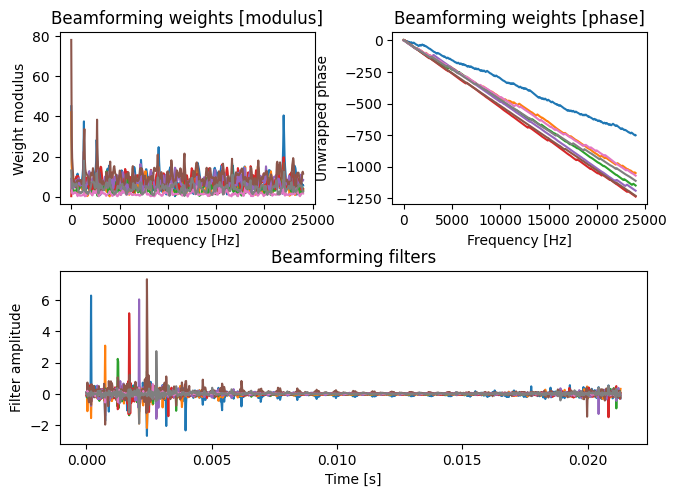

In [15]:
# plot beamformer info
mic_array.plot(FD=True)

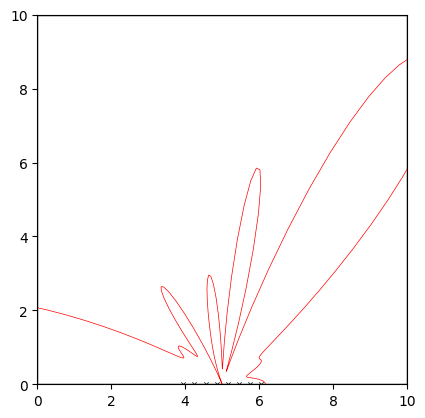

In [16]:
# plot beam pattern
room = pra.ShoeBox([10, 10], fs=fs)
room.add_microphone_array(mic_array)
fig, ax = room.plot(freq=[700], img_order=0)